In [83]:
from datetime import datetime
from backtester import Backtester
from starter_code import Strategy
import numpy as np
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import math as math
import pytz
pd.options.mode.chained_assignment = None

start = datetime(2024, 1, 1)
end = datetime(2024, 1, 3) #modify to only 3 weeks for performance purposes
s = Strategy()
#b = Backtester(start, end, s)

In [85]:
#set backtester in seperate cell since constructor will begin generating orders
b = Backtester(start, end, s)

Date: 2024-01-02 00:00:00
Percent done with day %0.0
Percent done with day %4.334445841099216
Percent done with day %8.668891682198431
Percent done with day %13.003337523297647
Percent done with day %17.337783364396863
Percent done with day %21.672229205496077
Percent done with day %26.006675046595294
Percent done with day %30.341120887694508
Percent done with day %34.675566728793726
Percent done with day %39.010012569892936
Percent done with day %43.344458410992154
Percent done with day %47.67890425209137
Percent done with day %52.01335009319059
Percent done with day %56.3477959342898
Percent done with day %60.682241775389016
Percent done with day %65.01668761648823
Percent done with day %69.35113345758745
Percent done with day %73.68557929868666
Percent done with day %78.02002513978587
Percent done with day %82.3544709808851
Percent done with day %86.68891682198431
Percent done with day %91.02336266308353
Percent done with day %95.35780850418274
Percent done with day %99.692254345281

In [86]:
#   TESTING OF THE GREEKS PARAMETERS

#testing d1 and d2 used in all greek calculations
S, K, r, t, sigma = 42, 40, .10, 0.5, .20,
calculated_d1 = s.d1(S,K,t,r,sigma)
text_book_d1 = 0.7693
assert abs(calculated_d1 - text_book_d1) < 0.0001

#d2
calculated_d2 = s.d2(S,K,t,r,sigma)
text_book_d2 = 0.6278
assert abs(calculated_d2 - text_book_d2) < 0.0001

# DELTA
S, K, r, t, sigma = 49, 50 ,0.05, 0.3846, 0.2
delta_calc = s.delta(S, K, t, r, sigma,'C')
# should get 0.521601633972
delta_text_book = 0.522
assert abs(delta_calc - delta_text_book) < .01

# THETA
theta_calc = s.theta(S, K, t, r, sigma,'C')
annual_theta_calc = theta_calc * 365
#print(annual_theta_calc)
annual_theta_textbook = -4.31
assert abs(annual_theta_calc - annual_theta_textbook) < .01

# GAMMA
gamma_calc = s.gamma(S, K, t, r, sigma,'C')
# 0.0655453772525
gamma_text_book = 0.066
assert abs(gamma_calc - gamma_text_book) < .001

# RHO
rho_calc = s.rho(S, K, t, r, sigma, 'C')
#print(rho_calc)
# 0.089065740988
rho_text_book = 0.0891
assert abs(rho_calc - rho_text_book) < .0001

# VEGA
vega_calc = s.vega(S, K, t, r, sigma,'C')
# should get 0.121052427542
#print(vega_calc)
vega_text_book = 0.121
assert abs(vega_calc - vega_text_book) < .01

#Now testing black sholes + implied volatility
S, K, sigma, r, t, action = 100, 100, .2, .01, .5, 'C'

price = s.black_scholes(S, K, t, r, sigma, action)
expected_price = 5.87602423383

print(price)
#assert price before finding volatility 
assert abs(expected_price - price) < 0.00001

iv = s.find_sigma_with_scipy(price, S, K, t, r, action)
expected_iv = 0.2

print(iv)

assert abs(expected_iv - iv) < 0.00001

#testing black sholes with puts
# S, K, sigma, r, t, action = 4702.8701171875, 7000, .2, .05, .958904, 'P'

# price = s.black_scholes(S, K, t, r, sigma, action)
# expected_price = 5.87602423383

S, K, sigma, r, t, action = 4702.8701171875, 7000, 0.2, 0.05, 0.958904, 'P'
d1 = Strategy.d1(S, K, t, r, sigma)
d2 = Strategy.d2(S, K, t, r, sigma)
price = Strategy.black_scholes(S, K, t, r, sigma, action)
expected_price = 5.87602423383

print(f"d1: {d1}")
print(f"d2: {d2}")
print(f"Calculated price: {price}")
print(f"Expected price: {expected_price}")
print(f"Difference: {abs(expected_price - price)}")

print(price)
#assert price before finding volatility 
assert abs(expected_price - price) < 0.00001


5.876024233827607
0.19999999999997792
d1: -1.6881208200435527
d2: -1.8839681074896648
Calculated price: 1985.592913252126
Expected price: 5.87602423383
Difference: 1979.716889018296
1985.592913252126


AssertionError: 

In [82]:
def test_black_scholes():
    # Test case 1: Deep in-the-money put option
    S, K, T, r, sigma, option_type = 4702.8701171875, 7000, 0.958904, 0.05, 0.2, 'P'
    price = Strategy.black_scholes(S, K, T, r, sigma, option_type)
    
    # Calculate bounds
    intrinsic_value = max(0, K - S)
    upper_bound = K * np.exp(-r * T)
    
    print(f"Calculated price: {price}")
    print(f"Intrinsic value: {intrinsic_value}")
    print(f"Upper bound: {upper_bound}")
    
    assert intrinsic_value <= price <= upper_bound, f"Price {price} is out of expected range [{intrinsic_value}, {upper_bound}]"
    
    # Test case 2: At-the-money call option
    S, K, T, r, sigma, option_type = 100, 100, 0.5, 0.05, 0.2, 'C'
    price = Strategy.black_scholes(S, K, T, r, sigma, option_type)
    
    # For call options, we can use a simple sanity check
    assert 0 <= price <= S, f"Call option price {price} should be between 0 and {S}"
    
    # Test case 3: Out-of-the-money put option
    S, K, T, r, sigma, option_type = 110, 100, 0.5, 0.05, 0.2, 'P'
    price = Strategy.black_scholes(S, K, T, r, sigma, option_type)
    
    assert 0 <= price <= K * np.exp(-r * T), f"Put option price {price} should be between 0 and {K * np.exp(-r * T)}"
    
    print("All tests passed!")

test_black_scholes()

Calculated price: 1985.592913252126
Intrinsic value: 2297.1298828125
Upper bound: 6672.302141681485


AssertionError: Price 1985.592913252126 is out of expected range [2297.1298828125, 6672.302141681485]

SPX   240119P04700000


Text(0, 0.5, 'Price')

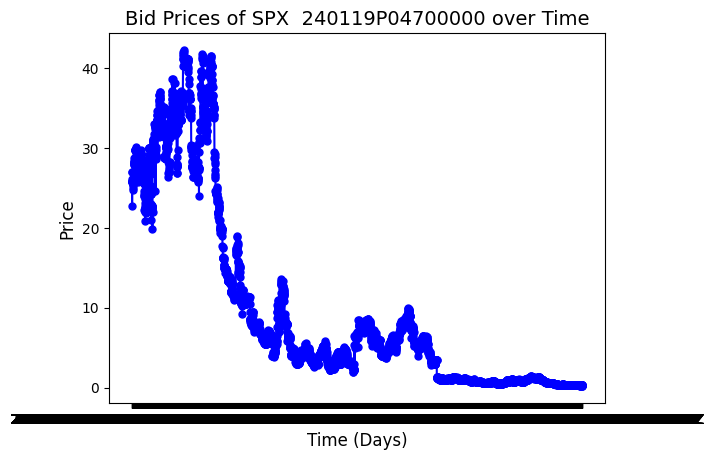

In [87]:
current_date = b.start_date
delta: timedelta = timedelta(days=1)
Data = {}
print(b.options["symbol"][0])

rslt_df = b.options.loc[b.options['symbol'] == 'SPX   240119P04700000'] 

plt.plot(rslt_df["ts_recv"],rslt_df["bid_px_00"], label="SPX   240119P04700000", color="blue", marker="o", linestyle="-", markersize=5)

plt.title("Bid Prices of SPX  240119P04700000 over Time", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Price", fontsize=12)


# theortical price



In [88]:
#S stands for strike price, K is underlying price, 
# to get underlying price, use alr asked bid price, 
#T current time divided, 
#r is the risk free rate (0.03), sigma is volatility
#sigma is our free variable 
def cdf(self, x):
        return 0.5*(1+math.erf(x/math.sqrt(2)))

#implement the testing window accurate

def black_scholes(self, S, K, T, r, sigma, option='call'):
    d1 = (math.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))
    d2 = (math.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * math.sqrt(T))

    if option == 'call':
        return S * self.cdf(d1) - K * math.exp(-r * T) * self.cdf(d2)
    if option == 'put':
        return K * math.exp(-r * T) * self.cdf(-d2) - S * self.cdf(-d1)

In [96]:
import py_vollib 
from py_vollib.black_scholes  import black_scholes as bs
from py_vollib.black_scholes.implied_volatility import implied_volatility as iv
from py_vollib.black_scholes.greeks.analytical import delta 
from py_vollib.black_scholes.greeks.analytical import gamma
from py_vollib.black_scholes.greeks.analytical import rho
from py_vollib.black_scholes.greeks.analytical import theta
from py_vollib.black_scholes.greeks.analytical import vega
import numpy as np

"""
price (float) the Black-Scholes option price
S (float) underlying asset price
sigma (float) annualized standard deviation, or volatility
K (float) strike price
t (float) time to expiration in years
r (float) risk-free interest rate
flag (str) 'c' or 'p' for call or put.
"""
def greek_val(price,flag, S, K, t, r, sigma):
    #implied volatility will be our sigma for rest of greek calculations
    sigma = iv(price, S, K, t, r, flag) 
    delta_calc = delta(flag, S, K, t, r, sigma)
    gamma_calc = gamma(flag, S, K, t, r, sigma)
    rho_calc = rho(flag, S, K, t, r, sigma)
    theta_calc = theta(flag, S, K, t, r, sigma)
    vega_calc = vega(flag, S, K, t, r, sigma)
    return np.array([ price, sigma ,theta_calc, delta_calc ,rho_calc ,vega_calc ,gamma_calc])

Text(0, 0.5, 'Price (Dollars)')

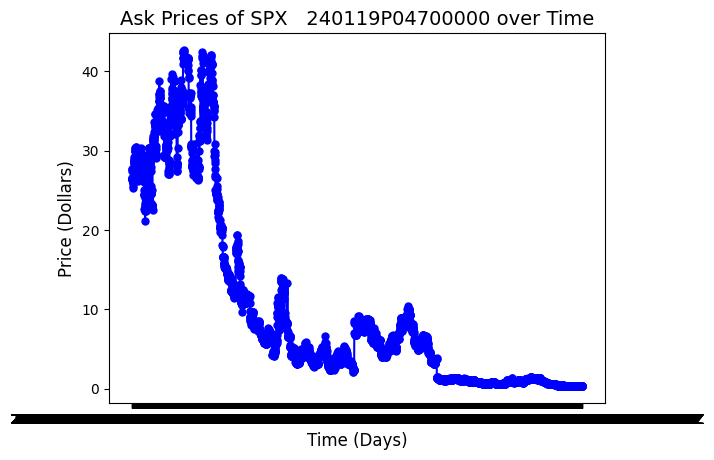

In [90]:
plt.plot(rslt_df["ts_recv"],rslt_df["ask_px_00"], label="SPX   240119P04700000", color="blue", marker="o", linestyle="-", markersize=5)

plt.title("Ask Prices of SPX   240119P04700000 over Time", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("Price (Dollars)", fontsize=12)

In [97]:
# Read the CSV file
underlying = pd.read_csv("data/underlying_data_hour.csv")

# Convert the date column to datetime with UTC timezone
underlying['date'] = pd.to_datetime(underlying['date'], format='%Y-%m-%d %H:%M:%S%z', utc=True)

# Convert UTC to America/New_York timezone
underlying['date'] = underlying['date'].dt.tz_convert('America/New_York')

# Create a timezone-aware datetime object for filtering
date = datetime.strptime("2024-01-02", "%Y-%m-%d").replace(tzinfo=pytz.timezone('America/New_York'))

# Filter the data for the specific date
data = underlying[underlying['date'].dt.date == date.date()]

# Check if data is not empty before accessing the first row
if not data.empty:
    print("First open value:", data['open'].iloc[0])
else:
    print("No data found for the specified date.")

# # For debugging:
# print("\nDate column type:", underlying['date'].dtype)
# print("\nFirst few date values:")
# print(underlying['date'].head())

data['open'].iloc[0]

First open value: 4745.2001953125


np.float64(4745.2001953125)

In [99]:
#THIS CELL CALCULATES THE GIVEN STRATEGY OVER A SLIDING WINDOW OF A MONTH TO VERIFY OUR STRATEGY WORKS OVER ALL CIRCUMSTANCES

results = pd.DataFrame({"Start": [], "End": [], "Score":[]}) #start, end dates, overall score
delta: timedelta = timedelta(days=1)
current_date: datetime = b.start_date

final_end_date = b.end_date

b.end_date =  b.start_date + timedelta(days=30) #length of each test is a month 

while b.end_date <= final_end_date: #stop execution when last 1 month period before end date is done
    #do trial run over the sliding window of dates
    test = Backtester(b.start_date, b.end_date, s)
    test.calculate_pnl()
    test.compute_overall_score()
    #add new row, can include more information in future or directly inject test object info
    new_row = {
        "Start": test.start_date.strftime("%Y-%m-%d"),  # Convert to string
        "End": test.end_date.strftime("%Y-%m-%d"),     # Convert to string
        "Score": test.overall_score
    }
    # results.append(new_row, ignore_index=True)
    results - pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)
    #increment by both bounds by 1
    b.end_date += timedelta(days=1)
    b.start_date += timedelta(days=1)

Date: 2024-01-02 00:00:00
Percent done with day %0.0
Percent done with day %4.334445841099216
Percent done with day %8.668891682198431
Percent done with day %13.003337523297647
Percent done with day %17.337783364396863
Percent done with day %21.672229205496077
Percent done with day %26.006675046595294
Percent done with day %30.341120887694508
Percent done with day %34.675566728793726
Percent done with day %39.010012569892936
Percent done with day %43.344458410992154
Percent done with day %47.67890425209137
Percent done with day %52.01335009319059
Percent done with day %56.3477959342898
Percent done with day %60.682241775389016
Percent done with day %65.01668761648823
Percent done with day %69.35113345758745
Percent done with day %73.68557929868666
Percent done with day %78.02002513978587
Percent done with day %82.3544709808851
Percent done with day %86.68891682198431
Percent done with day %91.02336266308353
Percent done with day %95.35780850418274
Percent done with day %99.692254345281

/var/folders/tr/83h5l7z97tgg514w38p86xk80000gn/T/ipykernel_16423/1696837150.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results - pd.concat([results, pd.DataFrame([new_row])], ignore_index=True)


TypeError: cannot subtract DatetimeArray from ndarray

In [93]:
b.calculate_pnl()

2024-01-01 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-02 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-03 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-04 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-05 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-06 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-07 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-08 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-09 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-10 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-11 00:00:00 capital: 100000000 portfolio value: 0 to

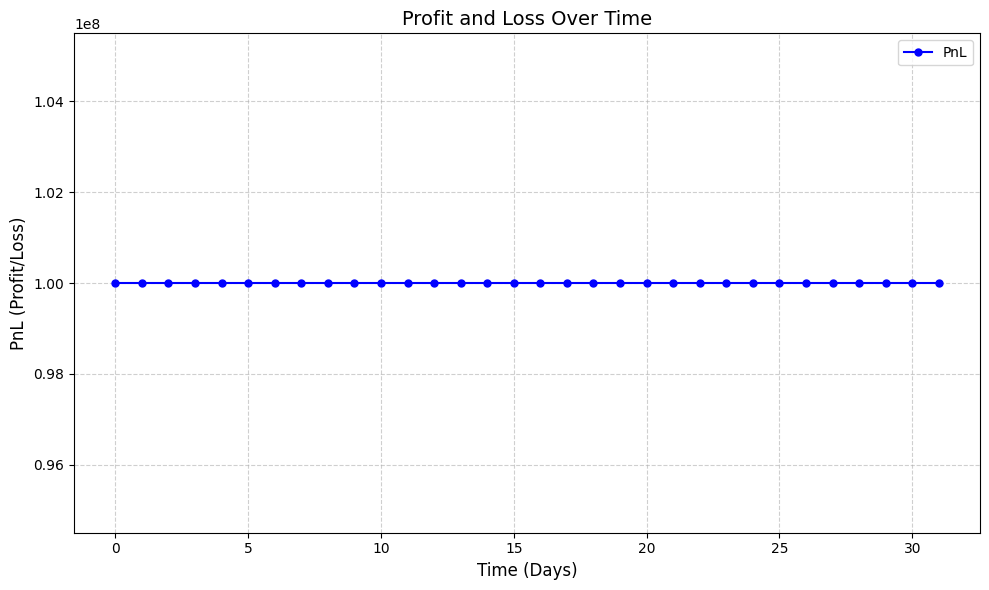

In [94]:
b.plot_pnl()

# get the theortical value of the contract on a given day, find options where money is misplaced and buy when cheap

In [95]:
b.compute_overall_score()

Max Drawdown: 0.0
Overall Return: 0.0%
Sharpe Ratio: Undefined (Standard Deviation = 0)
Cannot calculate overall score (Max Drawdown or Sharpe Ratio <= 0)
